In [135]:
import os
import random
import keras
import numpy as np

print(os.getcwd())

E:\py-project\dog_cat


In [129]:
#### 图片文件预处理
import shutil

if os.path.exists('slink'):
    pass
else:
    os.mkdir('slink')

if os.path.exists(r'slink\cat'):
    shutil.rmtree(r'slink\cat')
    os.mkdir('slink\cat')
else:
    os.mkdir('slink\cat')

if os.path.exists(r'slink\dog'):
    shutil.rmtree(r'slink\dog')
    os.mkdir('slink\dog')
else:
    os.mkdir('slink\dog')
    
for file in os.listdir('train'):
    if (file.split(sep='.')[0]=='cat'):
        os.symlink('./train/'+file,'./slink/cat/'+file)
    else:
        os.symlink('./train/'+file,'./slink/dog/'+file)

In [134]:
print('total train number:{}'.format(len(os.listdir('train'))))
print('cats number:{}'.format(len(os.listdir('slink/cat'))))
print('dogs number:{}'.format(len(os.listdir('slink/dog'))))

total train number:25000
cats number:12500
dogs number:12500


In [ ]:
def get_files(file_dir,shuffle=True):
	cats=[]
	label_cats=[]
	dogs=[]
	label_dogs=[]
	
	#check dir
	if (os.path.isdir('.\cats')):
		pass
	else:
		os.mkdir('.\cats')
		
	if (os.path.isdir('.\dogs')):
		pass
	else:
		os.mkdir('.\dogs')
	
	# link to different path
	for file in os.listdir(file_dir):
		name=file.split(sep='.')
		if name[0]=='cat':
			cats.append

In [132]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py

def write_gap(MODEL,image_size,lambda_func=None):
    width = image_size[0]
    height=image_size[1]
    input_tensor=Input((height,width,3))
    x=input_tensor
    
    if lambda_func:
        x=Lambda(lambda_func)(x)
    
    base_model=MODEL(input_tensor=x,weights='imagenet',include_top=False)
    model=Model(base_model.input,GlobalAveragePooling2D()(base_model.output))
    
    gen=ImageDataGenerator()
    train_generator =gen.flow_from_directory("slink",image_size,shuffle=False,batch_size=16)
    test_generator  =gen.flow_from_directory("slink",image_size,shuffle=False,batch_size=16,class_mode=None)
    
    train=model.predict_generator(train_generator,train_generator.nb_sample)
    test=model.predict_generator(test_generator,test_generator.nb_sample)
    
    with h5py.File("gap_%s.h5"%MODEL.func_name) as h:
        h.create_dataset("train",data=train)
        h.create_dataset("test",data=test)
        h.create_dataset("lable",data=train_generator.classes)
        

In [ ]:
import h5py
import numpy as np
from sklearn.utils import shuffle

np.random.seed(2017)

X_train=[]
X_test=[]

for filename in ["gap_ResNet50.h5","gap_Xception.h5","gap_InceptionV3.h5"]:
    with h5py.File(filename,'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train=np.array(h['lable'])
        
X_train=np.concatenate(X_train,axis=1)
X_test=np.concatenate(X_test,axis=1)

X_train,y_train=shuffle(X_train,y_train)


In [ ]:
from keras.models import *
from keras.layers import *

np.ramdom.seed(2017)

input_tensor=Input(X_train.shape[1:])
x=Dropout(0.5)(input_tensor)
x=Dense(1,activation='sigmoid')(x)

model=Model(input_tensor,x)

model.compile(optimizer='adadelta',loss='binary_crossentorpy',metrics=['accuracy'])

model.fit(X_train,y_train,batch_size=128,nb_epoch=8,validation_split=0.2)

y_pred=model.predict(X_test,verbose=1)
y_pred=y_pred.clip(min=0.005,max=0.995)

In [ ]:
import pandas as pd
from keras.preprocessing.image import *

df=pd.read_csv("sample_submission.csv")

gen=ImageDataGenerator()

test_generator=gen.flow_from_directory("test",(224,224),shuffle=False,batch_size=16,class_mode=None)

for i,fname in enumerate(test_generator.filenames):
    index=int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1,'lable',y_pred[i])
    
df.to_csv('pred.csv',index=None)

df.head(10)

https://blog.csdn.net/SusanZhang1231/article/details/73249978

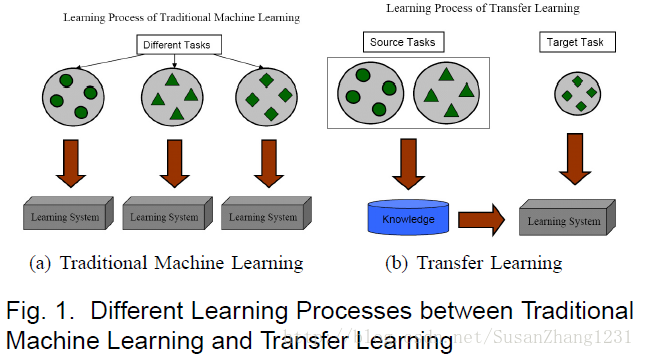